In [1]:
import pickle
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import torch.nn.functional as F
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl

from monai import transforms as tn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

from torchvision.models import resnet18, resnet50, densenet121
from torch import nn
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import CometLogger

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

# Load One Data

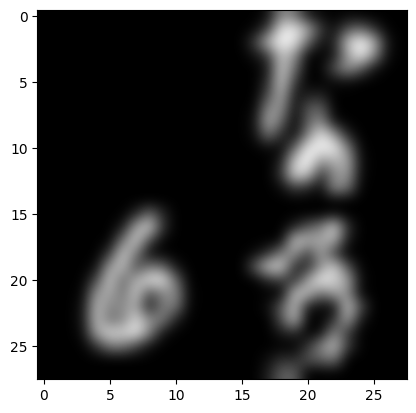

In [11]:
# Read a pickle file and disply its samples

data = pickle.load( open( 'Train.pkl', 'rb' ))
targets = np.genfromtxt('Train_labels.csv', delimiter=',')
plt.imshow(data[1208][0], cmap='gray', interpolation="bicubic")
plt.show()


# Create Dataset & Data Loader

In [12]:
class CustomTensorDataset(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = data_X.clone().detach(), data_y.clone().detach()
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transforms:
            x = self.transforms(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    tn.RandAffine(rotate_range=[8*(2*np.pi/360), 8*(2*np.pi/360), 8*(2*np.pi/360)],
                   shear_range=[0.08 for _ in range(6)], prob=0.1),
    tn.RandAdjustContrast(prob=0.2, gamma=(2/3, 3/2) )
])

# Read image data and their label into a Dataset 
train_data = pickle.load( open( 'Train.pkl', 'rb' ))
train_targets = pd.read_csv('Train_labels.csv', delimiter=',', index_col=0)
train_targets = train_targets.to_numpy()

In [14]:
data_size = train_data.shape[0]

data = train_data
data = torch.from_numpy(data)
targets = train_targets
targets = torch.from_numpy(targets)

In [15]:
data_set = CustomTensorDataset((data, targets), transform_list=transform)

In [16]:
# use 20% of training data for validation
train_set_size = int(len(data_set) * 0.8)
valid_set_size = len(data_set) - train_set_size
seed = torch.Generator().manual_seed(42)
train_set, validation_set = torch.utils.data.random_split(data_set, [train_set_size, valid_set_size], generator=seed)

In [17]:
test_data = pickle.load(open('Test.pkl', 'rb'))
test_data = torch.from_numpy(test_data)
test_set = TensorDataset(test_data)

In [18]:
batch_size = 128 # test [64, 128, 256]
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
dataloader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=8, shuffle=False, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

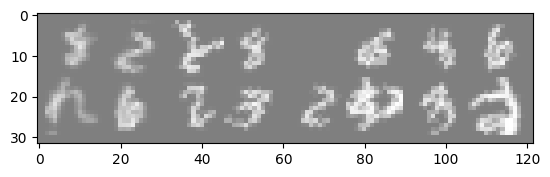

In [19]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

vis_train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

# get some random training images
dataiter = iter(vis_train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))

# RestNet


In [11]:
model = resnet18(num_classes=10)

Check model graph to change head and first layer according to our data:

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
# we should change first layer as below:

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Add comet_ml for logging metrics, hyperparameters and plots:

In [14]:
comet_logger_res18 = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    save_dir=".",  # Optional
    project_name="mini-project3",  # Optional
    experiment_name=f"resnet18_{random.randint(1, 10e4)}", # Optional
)

# don't forgert to close comet.experiment afterwards

CometLogger will be initialized in online mode


In [15]:
class ResNet18MNIST(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        
        self.model = resnet18()
        
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(512, num_classes, bias=True)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
  
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"train_loss": loss,"train_acc": self.accuracy(logits, y)})
        return loss

    def validation_step(self, batch, batch_no):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        val_loss = self.loss(logits, y)
        self.log("val_loss", val_loss, sync_dist=True)
        self.log('val_acc', self.val_accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"validation_loss": val_loss, "validation_acc": self.val_accuracy(logits, y)})
        return val_loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.005)
#         return torch.optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-5, betas=(0.05,0.95))

In [16]:
model = ResNet18MNIST()


In [17]:
trainer = pl.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=64, 
    logger = comet_logger_res18
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


First we need to fit model with 80% of data and validate on other 20% remaining:


In [ ]:
trainer.fit(model, train_loader, validation_loader)
trainer.validate(model, validation_loader)

After finding the best hyperparameters, we would retrain our model on the whole dataset in order to have the best possible accuracy on test set:

In [18]:
trainer.fit(model, dataloader)

/home/rain/nimafh/mini-project3/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type               | Params
----------------------------------------------------
0 | accuracy     | MulticlassAccuracy | 0     
1 | val_accuracy | MulticlassAccuracy | 0     
2 | model        | ResNet             | 11.2 M
3 | loss         | CrossEntropyLoss   | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARN

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=64` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [30616]  : (0.0546875, 1.0)
COMET INFO:     train_loss [30616] : (5.117632827023044e-05, 20.71371078491211)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet18_44177
COMET INFO:   Parameters:
COMET INFO:     num_classes : 10
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         

We would revalidate on the 20% to measure if our model could possible overfit on observed data or not:

In [19]:
trainer.validate(model, validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b



Validation: 0it [00:00, ?it/s]

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     val_acc              : 0.9957500100135803
COMET INFO:     val_loss             : 0.014565203338861465
COMET INFO:     validation_acc [94]  : (0.9765625, 1.0)
COMET INFO:     validation_loss [94] : (0.00010124405525857583, 0.11702810227870941)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet18_44177
COMET INFO:   Parameters:
COMET INFO:     num_classes : 10
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9957500100135803
        val_loss           0.014565203338861465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.014565203338861465, 'val_acc': 0.9957500100135803}]

## Prediction
Get Predictions, create csv output, and saving a checkpoint

Save the best model as follow:

In [20]:
def save_checkpoint(trainer, save_path):
    trainer.save_checkpoint(save_path)
# Example
# save_checkpoint(trainer, "resnet18_Jmnist_final.pt") 

In [21]:
def get_prediction(x, model: pl.LightningModule):
    model.freeze() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities

In [22]:
from tqdm.autonotebook import tqdm
def create_prediction(test_loader, net):
    counter = 0
    for batch in tqdm(iter(test_loader), total=len(test_loader)):
        x = batch[0]
        preds, probs = get_prediction(x, net)
        if counter == 0:
            counter += 1
            preds_total = preds.data.cpu().numpy()
        else:
            preds_total = np.concatenate([preds_total, preds.data.cpu().numpy()], axis=0)
    return preds_total

save outpus as .csv file for kaggle:

In [23]:
def save_output(outputs: list, save_path):
    import csv
    
    header = ['id', 'class']

    # open the file in the write mode
    with open(save_path, 'w') as f:
        # create the csv writer
        writer = csv.writer(f)
        writer.writerow(header)

        for i in range(len(outputs)):
                writer.writerow([i, outputs[i]])
    

In [25]:
preds_total = create_prediction(test_loader, model)
save_output(preds_total, "./results/res18_final.csv")

  0%|          | 0/79 [00:00<?, ?it/s]

You can load a saved model and validate or test on it as follow:

In [27]:
inference_model = ResNet18MNIST.load_from_checkpoint("resnet18_Jmnist2.pt", map_location="cuda")
trainer.validate(inference_model, validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b



Validation: 0it [00:00, ?it/s]

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     val_acc              : 0.9903333187103271
COMET INFO:     val_loss             : 0.04628358036279678
COMET INFO:     validation_acc [94]  : (0.96875, 1.0)
COMET INFO:     validation_loss [94] : (3.096918226219714e-05, 0.25150808691978455)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet18_44177
COMET INFO:   Parameters:
COMET INFO:     num_classes : 10
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the foll

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9903333187103271
        val_loss            0.04628358036279678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.04628358036279678, 'val_acc': 0.9903333187103271}]

In [28]:
preds_total.shape

(10000,)

In [33]:
comet_logger_res18.experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/8c03e8bbf52f4e8d9f6ddbb937f63c3b
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet18_44177
COMET INFO: ------------------

Best res18:

After fine-tunning we achieved 90.1% with Resnet18 on kaggle public leaderboard.


## RESNET50


In [29]:
res50 = resnet50(num_classes=10)

In [30]:
res50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
res50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [34]:
class ResNet50MNIST(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.model = resnet50()
            
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(2048, num_classes, bias=True)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
  
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"train_loss": loss,"train_acc": self.accuracy(logits, y)})
        return loss
    
    def validation_step(self, batch, batch_no):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        val_loss = self.loss(logits, y)
        self.log("validation_loss", val_loss, sync_dist=True)
        self.log('validation_acc', self.val_accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"validation_loss": val_loss, "validation_acc": self.val_accuracy(logits, y)})
        return val_loss
    
    def configure_optimizers(self):
#         return torch.optim.RMSprop(self.parameters(), lr=0.001)
        return torch.optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-5, betas=(0.05,0.95))

In [35]:
res50 = ResNet50MNIST()
comet_logger_res50 = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    save_dir=".",  # Optional
    project_name="mini-project3",  # Optional
    experiment_name=f"resnet50_final_{random.randint(1, 10e4)}", # Optional
)

trainer_res50 = pl.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=128,
    logger=comet_logger_res50
)
trainer_res50.fit(res50, dataloader)


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type               | Params
----------------------------------------------------
0 | accuracy     | MulticlassAccuracy | 0     
1 | val_accuracy | MulticlassAccuracy | 0     
2 | model        | ResNet             | 23.5 M
3 | loss         | CrossEntropyLoss   | 0     
----------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.089    Total estimated model params size (MB)
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environ

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=128` reached.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/bb4460c0cd4244c7ab9ff6f12600b1d1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_acc [61232]  : (0.0625, 1.0)
COMET INFO:     train_loss [61232] : (4.88080877403263e-06, 13.960657119750977)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet50_final_13046
COMET INFO:   Parameters:
COMET INFO:     num_classes : 10
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model graph         : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code     

2022-12-02 17:42:29,793 - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))': /api/rest/v2/experiment/metadata?experimentKey=bb4460c0cd4244c7ab9ff6f12600b1d1


### close comet_logger experiment

In [41]:
comet_logger_res50.experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/bb4460c0cd4244c7ab9ff6f12600b1d1

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/bb4460c0cd4244c7ab9ff6f12600b1d1
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet50_final_13046
COMET INFO: ------------

### Validate outputs

In [40]:
trainer_res50.validate(res50, validation_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/bb4460c0cd4244c7ab9ff6f12600b1d1



Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_acc         0.9962499737739563
     validation_loss       0.012615164741873741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/bb4460c0cd4244c7ab9ff6f12600b1d1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_acc [95]  : (0.9765625, 1.0)
COMET INFO:     validation_loss [95] : (9.382000280311331e-05, 0.06777729839086533)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : resnet50_final_13046
COMET INFO:   Parameters:
COMET INFO:     num_classes : 10
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: -----------------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and com

[{'validation_loss': 0.012615164741873741,
  'validation_acc': 0.9962499737739563}]

### Save Checkpoint

In [42]:
trainer_res50.save_checkpoint("resnet50_final.pt")

### Create Predictions

In [43]:
preds_total_res50 = create_prediction(test_loader, res50)

  0%|          | 0/79 [00:00<?, ?it/s]

### Save Output

In [44]:
save_output(preds_total_res50, './results/resnet50_final.csv')

# DenseNet121

In [24]:
# for train and validation set
transform2 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(94),
    transforms.ToTensor(),
    tn.RandAffine(rotate_range=[8*(2*np.pi/360), 8*(2*np.pi/360), 8*(2*np.pi/360)],
                   shear_range=[0.08 for _ in range(6)], prob=0.15),
    
    tn.RandAdjustContrast(prob=0.3, gamma=(2/3, 3/2)),
    transforms.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184]),
])

In [25]:
class CustomTensorDatasetDnet(Dataset):
    def __init__(self, dataset, transform_list=None):
        [data_X, data_y] = dataset
        X_tensor, y_tensor = data_X.clone().detach(), data_y.clone().detach()
        #X_tensor, y_tensor = Tensor(data_X), Tensor(data_y)
        tensors = (X_tensor, y_tensor)
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        trans = transforms.Lambda(lambda x: x.expand(3, -1, -1))
        x = trans(x)
        if self.transforms:
            x = self.transforms(x)
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)


In [26]:
data_set_dnet = CustomTensorDatasetDnet((data, targets), transform_list=transform2)

In [27]:
# use 20% of training data for validation
train_set_size = int(len(data_set) * 0.8)
valid_set_size = len(data_set) - train_set_size
seed = torch.Generator().manual_seed(42)
train_set_dnet, validation_set_dnet = torch.utils.data.random_split(data_set_dnet, [train_set_size, valid_set_size], generator=seed)

In [28]:
batch_size = 256 # test [64, 128, 256]
train_loader_dnet = DataLoader(train_set_dnet, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
dataloader_dnet = DataLoader(data_set_dnet, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True)
validation_loader_dnet = DataLoader(validation_set_dnet, batch_size=batch_size, num_workers=8, shuffle=False, persistent_workers=True)
test_loader_dnet = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [29]:
class DenseNet(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = densenet121()
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.model.classifier = nn.Linear(in_features=1024, out_features=10, bias=True)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
  
    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"train_loss": loss,"train_acc": self.accuracy(logits, y)})
        return loss
    
    def validation_step(self, batch, batch_no):
        x, y = batch
        y = y.view(-1)
        logits = self(x)
        val_loss = self.loss(logits, y)
        self.log("validation_loss", val_loss, sync_dist=True)
        self.log('validation_acc', self.val_accuracy(logits, y), prog_bar=True)
        self.logger.log_metrics({"validation_loss": val_loss, "validation_acc": self.val_accuracy(logits, y)})
        return val_loss
    
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=0.001)
#         return torch.optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-5, betas=(0.05,0.95))

We have used train validate procedure in another jupyter notebook and found the best hyperparameters for DenseNet121

The only thing needs to be investidated is the number of epoches (finding the best stopping point before overfitting)

In [30]:
comet_logger_dense121 = CometLogger(
    api_key=os.environ.get("COMET_API_KEY"),
    save_dir=".",  # Optional
    project_name="mini-project3",  # Optional
    experiment_name=f"dense121_final_{random.randint(1, 10e4)}", # Optional
)

dense121 = DenseNet()

trainer_densenet = pl.Trainer(
    devices=1,
    accelerator='gpu',
    max_epochs=48,
    logger=comet_logger_dense121
)


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer_densenet.fit(dense121, dataloader_dnet)

/home/rain/nimafh/mini-project3/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory ./mini-project3/736259c5e990437dade5329e22741624/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | DenseNet           | 7.0 M 
1 | accuracy     | MulticlassAccuracy | 0     
2 | val_accuracy | MulticlassAccuracy | 0     
3 | loss         | CrossEntropyLoss   | 0     
----------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.856    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=48` reached.


In [35]:
comet_logger_dense121.experiment.end()

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/736259c5e990437dade5329e22741624

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/736259c5e990437dade5329e22741624
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : dense121_final_85933
COMET INFO: ------------

In [32]:
trainer_densenet.validate(dense121, validation_loader_dnet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Validation: 0it [00:00, ?it/s]

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/nimafathi/mini-project3/736259c5e990437dade5329e22741624

COMET INFO: -----------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: -----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/nimafathi/mini-project3/736259c5e990437dade5329e22741624
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_acc [48]  : (0.984375, 1.0)
COMET INFO:     validation_loss [48] : (0.00011449

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     validation_acc         0.9978333115577698
     validation_loss       0.005610662512481213
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'validation_loss': 0.005610662512481213,
  'validation_acc': 0.9978333115577698}]

Create new test_loader in order to evaluate on test data 

In [36]:
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(94),
    transforms.ToTensor(),
    transforms.Normalize(
                                  [0.13141274452209473, 0.13141274452209473, 0.13141274452209473],
                                  [0.30904173851013184, 0.30904173851013184, 0.30904173851013184]),
])


class CustomTestTensorDatasetDnet(Dataset):
    def __init__(self, dataset, transform_list=None):
        data_X = dataset
        X_tensor = data_X.clone().detach()
        self.tensors = (X_tensor, )
        assert all(self.tensors[0].size(0) == tensor.size(0) for tensor in self.tensors)
        self.transforms = transform_list

    def __getitem__(self, index):
        x = self.tensors[0][index]
        trans = transforms.Lambda(lambda x: x.expand(3, -1, -1))
        x = trans(x)
        if self.transforms:
            x = self.transforms(x)
        return (x, x)
#         return tuple(tensor[index] for tensor in self.tensors)
        

    def __len__(self):
        return self.tensors[0].size(0)



In [37]:
test_set_dnet = CustomTestTensorDatasetDnet(test_data, transform_list=transform_test)
test_loader_dnet = DataLoader(test_set_dnet, batch_size=batch_size, shuffle=False)

In [38]:
# sanity check
len(test_set_dnet)

10000

### Save Checkpoint

In [39]:
trainer_densenet.save_checkpoint("densenet121_final_48.pt")

### Create Predictions

In [40]:
preds_total_dense121 = create_prediction(test_loader_dnet, dense121)

  0%|          | 0/40 [00:00<?, ?it/s]

### Save Output

In [41]:
save_output(preds_total_dense121, './results/densenet121_final_48.csv')